In [80]:
import numpy as np
import pandas as pd
import seaborn as sns
import os

In [2]:
import EpDDM2

In [3]:
import sys
import os
tornado_path = os.path.abspath('../tornado')
sys.path.insert(0, tornado_path)

In [4]:
from data_structures.attribute_scheme import AttributeScheme
from classifier.__init__ import *
from drift_detection.__init__ import *
from filters.project_creator import Project
from graphic.hex_colors import Color
from streams.readers.arff_reader import ARFFReader
from tasks.prequential_learner_detector_pairs import PrequentialMultiPairs

In [48]:
from importlib import reload
EpDDM2 = reload(EpDDM2)

In [49]:
CDDM = EpDDM2.EpDDM

In [56]:
def generate_data(n_samples, p, rate=0.5):
    # p = [ Pr(y=1|x=0), Pr(y=1|x=1) ]
    # rate is proportion of x=1 (rather than x=0)
    x = np.array([ np.random.choice(2, p=[1-rate, rate]) for i in range(n_samples) ])
    y = [ np.random.choice(2, p=[1-p[i], p[i]]) for i in x ]
    x = x.reshape(-1, 1)

    return x, y

class Experiment:
    
    pre_drift_n = 1000
    post_drift_n = 1000
    
    def __init__(self, probs, detector, model, rates, parameter=None):
        # probs = [a,b,c,d]
        # Before drift:
        # P(1|0) = a
        # P(1|1) = b
        # After drift:
        # P(1|0) = c
        # P(1|1) = d
        self.probs = probs
        self.detector = detector
        self.model = model
        self.result = None
        self.rates = rates
        self.parameter = parameter
        
    def run_experiment(self):
        x1, y1 = generate_data(Experiment.pre_drift_n, self.probs[:2], self.rates[0])
        x2, y2 = generate_data(Experiment.post_drift_n, self.probs[2:], self.rates[1])
        # return either none or the point of detection
        model = self.model
        if type(model)==str:
            model = eval(model)()
        detector = self.detector
        if type(detector)==str:
            detector = eval(detector)()
        monitor = []
        # Calibrate the detector
        for i in range(len(x1)):
            y_ = y1[i: i+1]
            x_ = x1[i: i+1]
            model.partial_fit(x_, y_, classes=[0,1])
            
            if type(detector)==EpDDM2.EpDDM:
                proba = model.predict_proba(x_)
                args = [proba, y_]
                try:
                    monitor.append(min(detector.hoeffding_bounds))
                except:
                    monitor.append(None)
            else:
                pred = model.predict([x_])
#                 print(pred, x_[0])
                pr = pred==y_
                args = [pr]
                monitor.append(pr)
                
            warning_status, drift_status = detector.detect(*args)
#         print(monitor)
#         print(detector.drift_threshold)
#         print('err rate', np.mean(np.array(prs).flatten()))
        monitor = []
        for i in range(len(x2)):
            y_ = y2[i: i+1]
            x_ = x2[i: i+1]
            
            if type(detector)==EpDDM2.EpDDM:
                proba = model.predict_proba(x_)
                args = [proba, y_]
                try:
                    monitor.append(min(detector.hoeffding_bounds))
                except:
                    monitor.append(None)
            else:
                pred = model.predict([x_])
#                 print(pred, /y_)
                pr = pred==y_
                args = [pr]
                monitor.append(pr)
                
            warning_status, drift_status = detector.detect(*args)
            
            if drift_status:
                self.result = i+1
#                 print('detected drift at', i)
                return i
#         print(monitor)
            
            # TODO: partial_fit model?
            
#            print(i, y_, x_, self.result)
        
        return
    
    def get_result_row(self):
        return pd.DataFrame({'Experiment': [f'{self.detector} + {self.model}'],
                            'Outcome': [self.result],
                           'Parameter': [self.parameter]})
    
class RepeatedExperiment:
    
    n_repeats = 1
    
    def __init__(self, probs, detector, model, rates):
        
        self.experiments = []
        self.detector = detector
        self.probs = probs
        self.model = model
        self.rates = rates
        
    def run_experiments(self):
#         print(self.detector, '\n\n')
        for i in range(RepeatedExperiment.n_repeats):
            new_experiment = Experiment(self.probs, self.detector, self.model, self.rates)
            new_experiment.run_experiment()
            self.experiments.append(new_experiment)
        
    def get_summary(self):
        results = [ exp.result for exp in self.experiments ]
        detections = [ i for i in results if i ]
        latency = np.mean(detections)
        try:
            recall = len(detections) / len(results)
        except:
            recall = 0
#         print(results)
        return {'latency': latency, 
                'detection_rate': recall }
    
class MultiDetectorExperiments:
    
    def __init__(self, probs, detectors, models, rates=[0.5, 0.5]):
        self.probs = probs
        self.detectors = detectors
        self.models = models
        self.repeated_experiments = {}
        self.rates = rates
        
    def run_experiments(self):
        for detector in self.detectors:
            for model in self.models:
                new_experiments = RepeatedExperiment(self.probs, eval(detector), eval(model), self.rates)
                new_experiments.run_experiments()
                name = f'{model} + {detector}'
                self.repeated_experiments[name] = new_experiments
        
    def results_table(self):
        table = pd.DataFrame(columns=['Experiment', 'Latency', 'Detection Rate'])
        i = 0
        for (name, repeated_experiment) in self.repeated_experiments.items():
            summary = repeated_experiment.get_summary()
            latency, detection_rate = summary['latency'], summary['detection_rate']
            table.loc[i] = [name, latency, detection_rate]
            
#             results = [ exp.result for exp in repeated_experiment.experiments ]
#             detections = [ i for i in results if i ]
#             print(detections)
#             latency = np.mean(detections)
            
            i += 1
        return table

In [57]:
class NaiveBayes:
    def __init__(self):
        self.counts = { 0: np.array([1,1]), 1: np.array([1,1])}
    def partial_fit(self, x, y, classes=None):
        for x_, y_ in zip(x, y):
            self.counts[x_[0]][y_] += 1
        return self
    def predict_proba(self, x):
        ret = []
        for x_ in x:
#             x_ = x_[0]
            while not type(x_)==np.int64 and not type(x_)==int:
                x_ = x_[0]
            ret.append( self.counts[x_]/np.sum(self.counts[x_]) )
        ret = np.array(ret)
        return ret
    def predict(self, x):
        probs = self.predict_proba(x)
        ret = [ max([0,1], key=lambda x: line[x]) for line in probs ]
        return ret

In [62]:
detectors = ['CDDM', 'HDDM_A_test', 'RDDM']
models = ['NaiveBayes']
rates = [0.5, 0.5]

def latency_experiment(epsilon, repeats=10):
    probs = [1-epsilon, epsilon, epsilon, 1-epsilon]
    results = pd.DataFrame(columns=['Experiment', 'Parameter', 'Outcome'])
    for i in range(repeats):
        for detector in detectors:
            for model in models:
                exp = Experiment(probs, detector, model, rates, epsilon)
                exp.run_experiment()
                results = results.append(exp.get_result_row())
    return results

latency_experiment(0.1, repeats=1)

,Experiment,Outcome,Parameter
0,CDDM + NaiveBayes,24,0.1
0,HDDM_A_test + NaiveBayes,5,0.1
0,RDDM + NaiveBayes,13,0.1


In [76]:
def latency_experiments(repeats=10):
    results = pd.DataFrame(columns=['Experiment', 'Parameter', 'Outcome'])
    for epsilon in np.linspace(0, 0.5, num=10):
        results = results.append(latency_experiment(epsilon, repeats))
    return results

latency = latency_experiments()

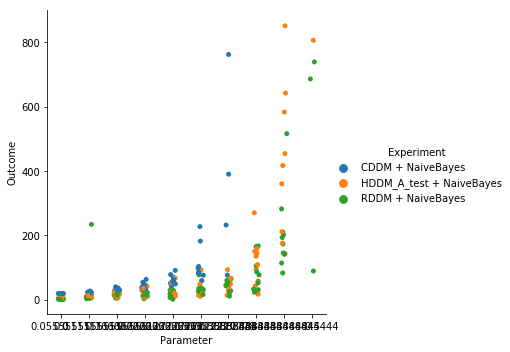

In [77]:
latency['Experiment'] = latency['Experiment'].astype('category')
sns.catplot(x='Parameter', y='Outcome', hue='Experiment', data=latency);

In [ ]:
detectors = ['CDDM', 'HDDM_A_test', 'RDDM']
models = ['NaiveBayes']
rates = [0.5, 0.5]

def high_noise_experiment(epsilon, repeats=10):
    probs = [0.5-epsilon, 0.5+epsilon, 0.5-epsilon, 0.5+epsilon]
    results = pd.DataFrame(columns=['Experiment', 'Parameter', 'Outcome'])
    for i in range(repeats):
        for detector in detectors:
            for model in models:
                exp = Experiment(probs, detector, model, rates, epsilon)
                exp.run_experiment()
                results = results.append(exp.get_result_row())
    return results

def high_noise_experiments(repeats=10):
    results = pd.DataFrame(columns=['Experiment', 'Parameter', 'Outcome'])
    for epsilon in np.linspace(0, 0.5, num=10):
        results = results.append(latency_experiment(epsilon, repeats))
    return results

high_noise = high_noise_experiments()

In [368]:
# Detection latency for high confidence
probs = [0.9, 0.1, 0.1, 0.9]


detectors = ['CDDM', 'HDDM_A_test', 'RDDM', 'DDM']
models = ['SimpleModel']

exp = MultiDetectorExperiments(probs, detectors, models)

exp.run_experiments()
exp.results_table()

[30]
[17]
[9]
[1]


,Experiment,Latency,Detection Rate
0,SimpleModel + CDDM,30.0,1.0
1,SimpleModel + HDDM_A_test,17.0,1.0
2,SimpleModel + RDDM,9.0,1.0
3,SimpleModel + DDM,1.0,1.0


In [364]:
# False positives with high noise
probs = [0.55, 0.45, 0.55, 0.45]

detectors = ['EpDDM2.EpDDM', 'HDDM_A_test', 'RDDM', 'DDM']
models = ['SimpleModel']

exp = MultiDetectorExperiments(probs, detectors, models)

exp.run_experiments()
exp.results_table()

[None]
[None]
[470]
[None]


,Experiment,Latency,Detection Rate
0,SimpleModel + EpDDM2.EpDDM,NaN,0.0
1,SimpleModel + HDDM_A_test,NaN,0.0
2,SimpleModel + RDDM,470.0,1.0
3,SimpleModel + DDM,NaN,0.0


In [316]:
# virtual drift masking real drift
probs = [1, 0.5, 1, 0.5]
rates = [0.01, 0.99]

detectors = ['EpDDM2.EpDDM', 'HDDM_A_test', 'RDDM', 'DDM']
models = ['SimpleModel']

exp = MultiDetectorExperiments(probs, detectors, models, rates)

exp.run_experiments()
exp.results_table()

,Experiment,Latency,Detection Rate
0,SimpleModel + EpDDM2.EpDDM,NaN,0.0
1,SimpleModel + HDDM_A_test,15.5,1.0
2,SimpleModel + RDDM,48.0,0.9
3,SimpleModel + DDM,2.0,0.2


They have three common parameters: the confidence values
170 for drifts (αD =0.001) and warnings (αW =0.005), and the direction of the error, which can be one-sided (t=0, only
increments), default for HDDMW , or two-sided (t=1, error increments and decrements), and default for HDDMA.
Finally, HDDMW has an extra parameter (λ=0.05) that is used to control how much weight is given to more recent
data in comparison to older data.

In [96]:
# Test
from data_structures.attribute_scheme import AttributeScheme
from classifier.__init__ import *
from drift_detection.__init__ import *
from filters.project_creator import Project
from graphic.hex_colors import Color
from streams.readers.arff_reader import ARFFReader
from tasks.prequential_learner_detector_pairs import PrequentialMultiPairs

def run_tornado_experiment(dataset_name):
    
    # 1. Creating a project
    project = Project("projects/multi", dataset_name)

    # 2. Loading an arff file
    labels, attributes, stream_records = ARFFReader.read(tornado_path + f"/data_streams/{dataset_name}_n_0.1/{dataset_name}_n_0.1_101.arff")
    attributes_scheme = AttributeScheme.get_scheme(attributes)

    # 3. Initializing a Classifier-Detector Pairs
    NaiveBayes(labels, attributes_scheme['nominal']) # TODO: does this line need to be here?
    pairs = [
             [NaiveBayes(labels, attributes_scheme['nominal']), CDDM()],
             [NaiveBayes(labels, attributes_scheme['nominal']), RDDM()],
             [NaiveBayes(labels, attributes_scheme['nominal']), HDDM_A_test()],
             [Perceptron(labels, attributes_scheme['numeric']), CDDM()],
             [Perceptron(labels, attributes_scheme['numeric']), RDDM()],
             [Perceptron(labels, attributes_scheme['numeric']), HDDM_A_test()]
            ]

    # 4. Creating a color set for plotting results
    colors = [Color.Indigo[1], Color.Blue[1], Color.Green[1], Color.Lime[1], Color.Yellow[1],
              Color.Amber[1], Color.Orange[1]][:len(pairs)]

    # 5. Defining actual locations of drifts, acceptance delay interval, and vector of weights
    actual_drift_points = [20000, 40000, 60000, 80000]
    drift_acceptance_interval = 250
    w_vec = [1, 1, 1, 1, 1, 1]

    # 6. Creating a Prequential Evaluation Process
    prequential = PrequentialMultiPairs(pairs, attributes, attributes_scheme,
                                        actual_drift_points, drift_acceptance_interval,
                                        w_vec, project, color_set=colors, legend_param=False)

    prequential.run(stream_records, 1)

The project path "projects/multi/sine1_w_50/20200203_112227/" is created.
NB + CDDM [0.0, 32.384, 502.92522108429694] [323, [80086, 4], 0, 0, 6.872, 26408.898005072842]
NB + RDDM [0.1426, 32.624, 586.2231042447092] [410, [80119, 4], 0, 0, 64.048, 114.411597893195]
NB + HDDM.A.test [0.1425, 32.624, 561.2747091472556] [213, [80046, 4], 1, 0, 1.312, 399.2994229411124]
PR + CDDM [0.0, 7.144, 261.35836894172826] [243, [80061, 4], 0, 0, 6.872, 26623.39278903164]
PR + RDDM [0.1253, 7.384, 357.51938744215295] [410, [80107, 4], 0, 0, 64.0, 105.89123392128386]
PR + HDDM.A.test [0.1257, 7.384, 307.4328950351628] [228, [80037, 4], 0, 0, 1.248, 394.2944059963338]
THE END



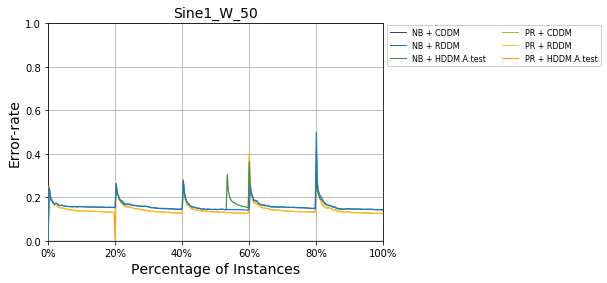

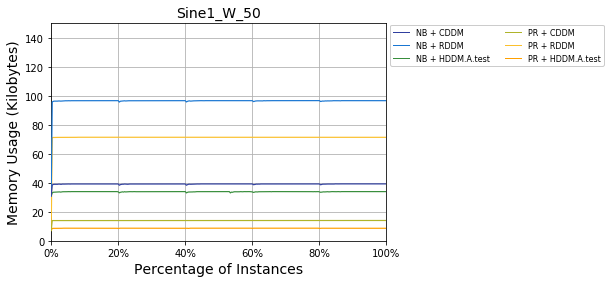

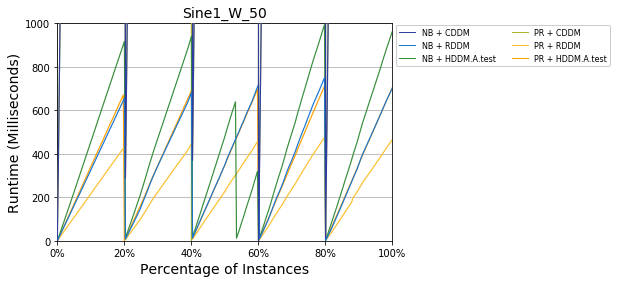

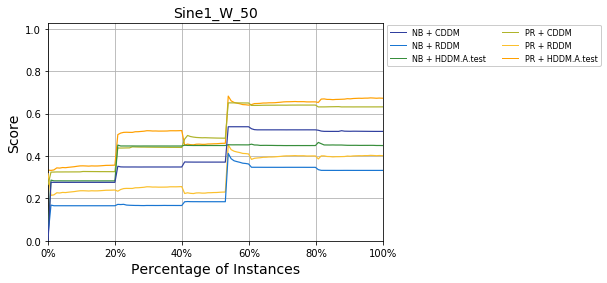

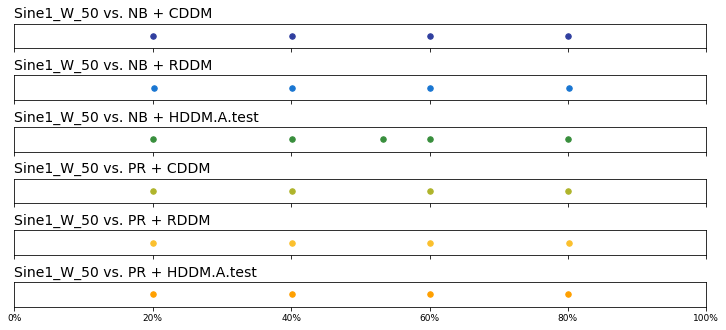

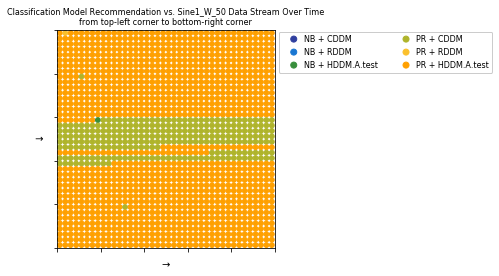

In [97]:
run_tornado_experiment('sine1_w_50')

The project path "projects/multi/circles_w_500/20200203_112801/" is created.
NB + CDDM [0.0, 32.32, 2678.276779508451] [1000, [0, 0], 0, 4, 6.872, 132965.25349503645]
NB + RDDM [0.1286, 32.592, 740.3044800448697] [1000, [0, 0], 3, 4, 64.048, 145.23966761043994]
NB + HDDM.A.test [0.1289, 32.624, 704.4924198526132] [1000, [0, 0], 5, 4, 1.312, 495.74628410482546]
PR + CDDM [0.0, 7.08, 1346.2911433562113] [1000, [0, 0], 0, 4, 6.872, 133327.05213402005]
PR + RDDM [0.3075, 7.384, 632.6641632549581] [910, [40161, 1], 6, 3, 64.048, 194.18797070466098]
PR + HDDM.A.test [0.2533, 7.384, 249.49792693951167] [1000, [0, 0], 4, 4, 1.312, 318.73827625531703]
THE END



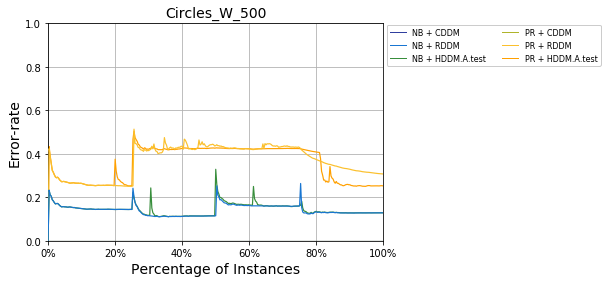

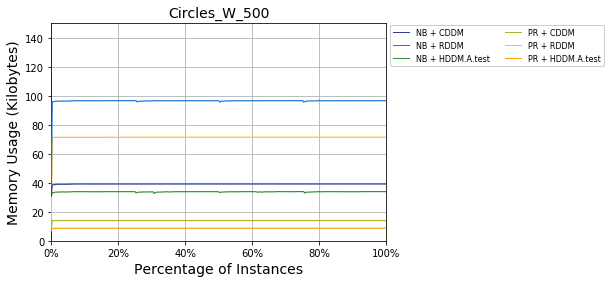

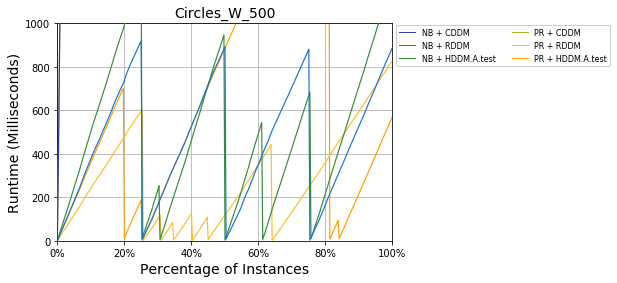

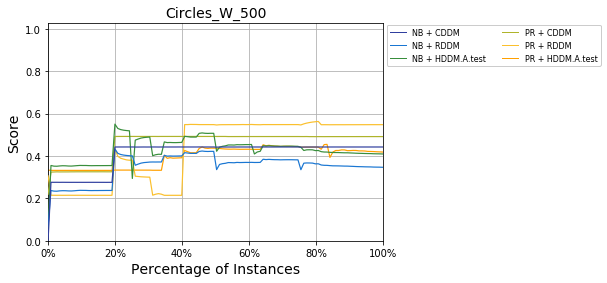

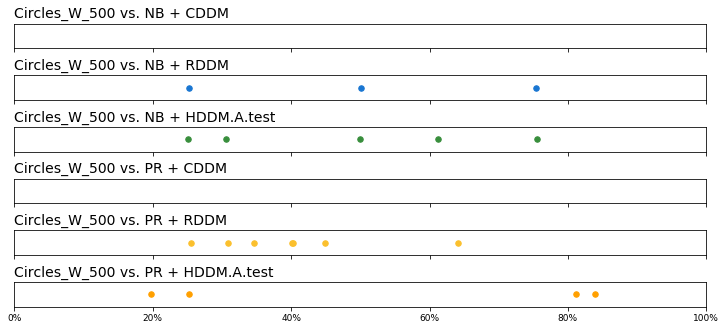

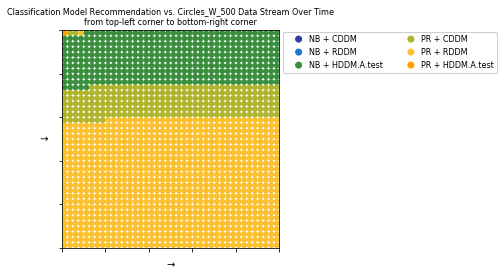

In [98]:
run_tornado_experiment('circles_w_500')

The project path "projects/multi/mixed_w_50/20200203_113339/" is created.
NB + CDDM [0.0, 39.168, 580.7655459102534] [350, [80084, 4], 0, 0, 6.872, 25901.953229913488]
NB + RDDM [0.134, 39.408, 669.5431970074424] [418, [80106, 4], 0, 0, 64.048, 111.45992368255975]
NB + HDDM.A.test [0.1338, 39.408, 665.5191095742339] [335, [80057, 4], 1, 0, 1.312, 395.5620308406651]
PR + CDDM [0.0, 8.92, 298.68043214446516] [306, [80065, 4], 0, 0, 6.872, 26236.86989910493]
PR + RDDM [0.1805, 9.192, 400.11455194689916] [500, [80141, 4], 0, 0, 64.048, 103.14123804346309]
PR + HDDM.A.test [0.1807, 9.192, 369.8395421015448] [413, [80058, 4], 0, 0, 1.312, 388.3358059429156]
THE END



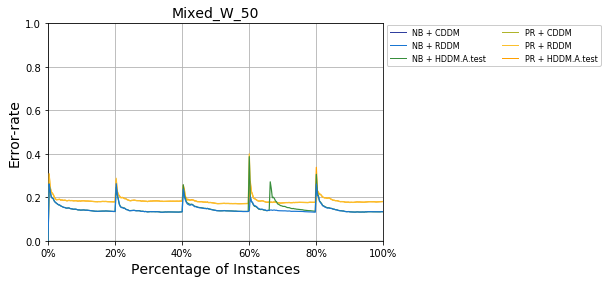

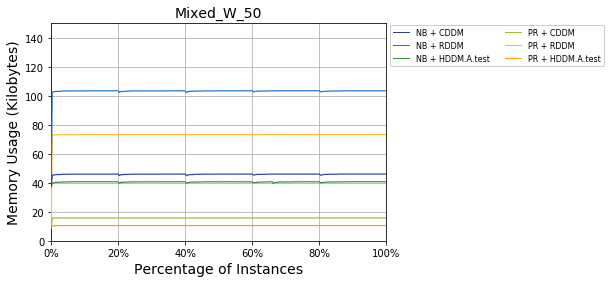

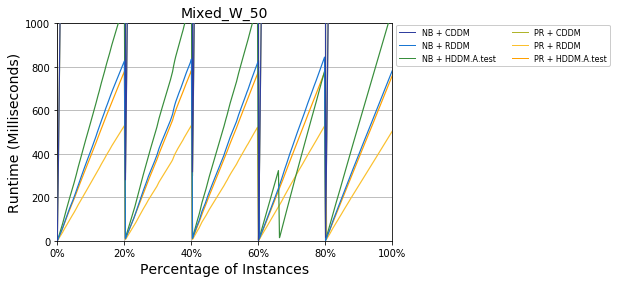

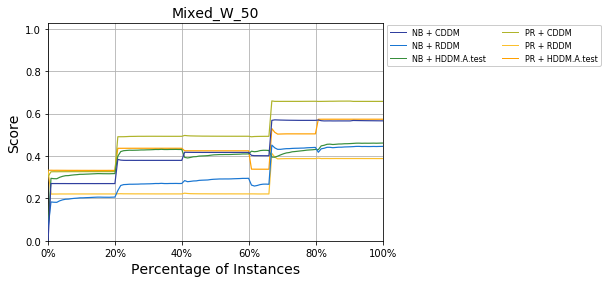

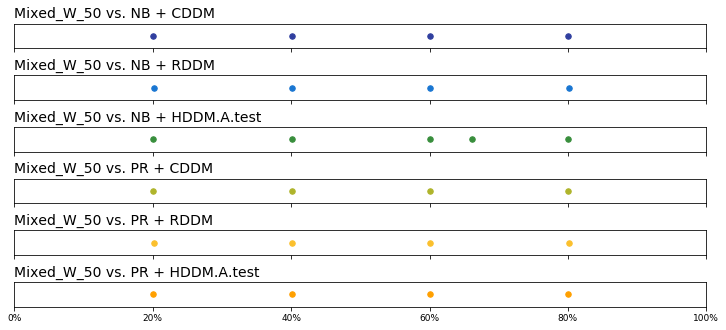

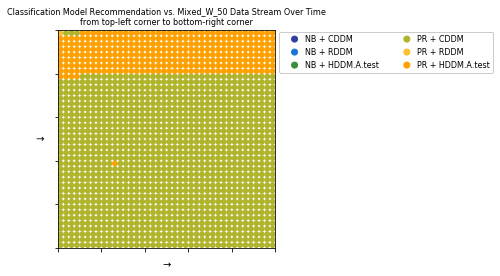

In [99]:
run_tornado_experiment('mixed_w_50')

In [ ]:
run_tornado_experiment('led_w_500')

The project path "projects/multi/led_w_500/20200203_115246/" is created.
23.68% of instances are processed!

In [111]:
def parse_results(path):
    path = os.path.abspath(path)
    with open(path) as f:
        lines = f.read().split('\n')
    headers = lines[0].rstrip(']').lstrip('[')
    headers = [ header.lstrip() for header in headers.split(',') ]
    results = pd.DataFrame(columns=headers)
    i = 1
    for line in lines[1:]:
        fields = line.split('\t')
        if fields==['']:
            continue
        results.loc[i, :] = fields
        i += 1
    # Parse "Drift Detector Stats"
    total_delay = []
    tp = []
    location_of_last_detection = []
    fp, fn = [], []
    for i in range(len(results)):
        temp = eval(results.loc[i+1, 'Drift Detector Stats'])
        tdi, [lldi, tpi], fpi, fni = temp
        total_delay.append(tdi)
        tp.append(tpi)
        location_of_last_detection.append(lldi)
        fp.append(fpi)
        fn.append(fni)
    results['Total Delay'] = total_delay
    results['TP'] = tp
    results['FN'] = fn
    results['FP'] = fp
    results = results.drop(columns='Drift Detector Stats')
        
    return results

dataset_name, exp_no = 'sine1_w_50/20200203_112227'.split('/')
circles_path = f"./projects/multi/{dataset_name}/{exp_no}/{dataset_name}.txt"
parse_results(circles_path)

,Name,Avg. Error-rate,Avg. Total Memory,Avg. Total Runtime,Avg. Score,Total Delay,TP,FN,FP
1,NAIVE BAYES + CDDM:,0.0,39.16,13528.19,0.42,323,4,0,0
2,NAIVE BAYES + RDDM:,15.909999999999998,96.49,350.07,0.25,410,4,0,0
3,NAIVE BAYES + HDDM.A.test:,16.14,33.86,433.49,0.42,213,4,0,1
4,PERCEPTRON + CDDM:,0.0,13.97,13324.82,0.52,243,4,0,0
5,PERCEPTRON + RDDM:,14.49,71.29,228.96,0.31,410,4,0,0
6,PERCEPTRON + HDDM.A.test:,14.549999999999999,8.68,349.33,0.54,228,4,0,0


In [112]:
dataset_name, exp_no = 'circles_w_500/20200203_112801'.split('/')
circles_path = f"./projects/multi/{dataset_name}/{exp_no}/{dataset_name}.txt"
parse_results(circles_path)

,Name,Avg. Error-rate,Avg. Total Memory,Avg. Total Runtime,Avg. Score,Total Delay,TP,FN,FP
1,NAIVE BAYES + CDDM:,0.0,39.15,68062.33,0.41,1000,0,4,0
2,NAIVE BAYES + RDDM:,14.26,96.45,449.47,0.35,1000,0,4,3
3,NAIVE BAYES + HDDM.A.test:,14.52,33.81,481.73,0.43,1000,0,4,5
4,PERCEPTRON + CDDM:,0.0,13.94,67474.28,0.46,1000,0,4,0
5,PERCEPTRON + RDDM:,36.79,71.3,278.18,0.43,910,1,3,6
6,PERCEPTRON + HDDM.A.test:,35.67,8.68,679.36,0.4,1000,0,4,4


In [ ]:
dataset_name, exp_no = 'mixed_w_50/20200203_113339'.split('/')
circles_path = f"./projects/multi/{dataset_name}/{exp_no}/{dataset_name}.txt"
parse_results(circles_path)